# Data Analysis

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ticker = "TCS.NS"
data = yf.download(ticker, start="2023-01-01", end="2024-01-31")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(data.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-01-02  3261.000000  3266.850098  3235.199951  3261.449951  3119.466553   
2023-01-03  3252.000000  3320.000000  3245.300049  3311.350098  3167.194336   
2023-01-04  3306.699951  3327.350098  3286.199951  3314.649902  3170.350586   
2023-01-05  3330.199951  3337.300049  3281.949951  3311.100098  3166.955078   
2023-01-06  3300.000000  3301.550049  3200.000000  3211.550049  3071.738770   

             Volume  
Date                 
2023-01-02   709547  
2023-01-03  1245178  
2023-01-04  1231668  
2023-01-05  1826057  
2023-01-06  2488376  


In [ ]:
missing_values = data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

Missing values in each column:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
data.fillna(method='ffill', inplace=True)

In [ ]:
data['20-Day MA'] = data['Close'].rolling(window=20).mean()
data['50-Day MA'] = data['Close'].rolling(window=50).mean()

In [ ]:
print(data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-01-02  3261.000000  3266.850098  3235.199951  3261.449951  3119.466553   
2023-01-03  3252.000000  3320.000000  3245.300049  3311.350098  3167.194336   
2023-01-04  3306.699951  3327.350098  3286.199951  3314.649902  3170.350586   
2023-01-05  3330.199951  3337.300049  3281.949951  3311.100098  3166.955078   
2023-01-06  3300.000000  3301.550049  3200.000000  3211.550049  3071.738770   
...                 ...          ...          ...          ...          ...   
2024-01-23  3900.000000  3933.899902  3842.750000  3858.250000  3830.409912   
2024-01-24  3880.000000  3883.649902  3805.600098  3841.800049  3814.078613   
2024-01-25  3839.899902  3861.000000  3778.699951  3810.300049  3782.805908   
2024-01-29  3800.800049  3820.000000  3780.850098  3801.000000  3773.572998   
2024-01-30  3807.449951  3847.800049  3787.000000  3

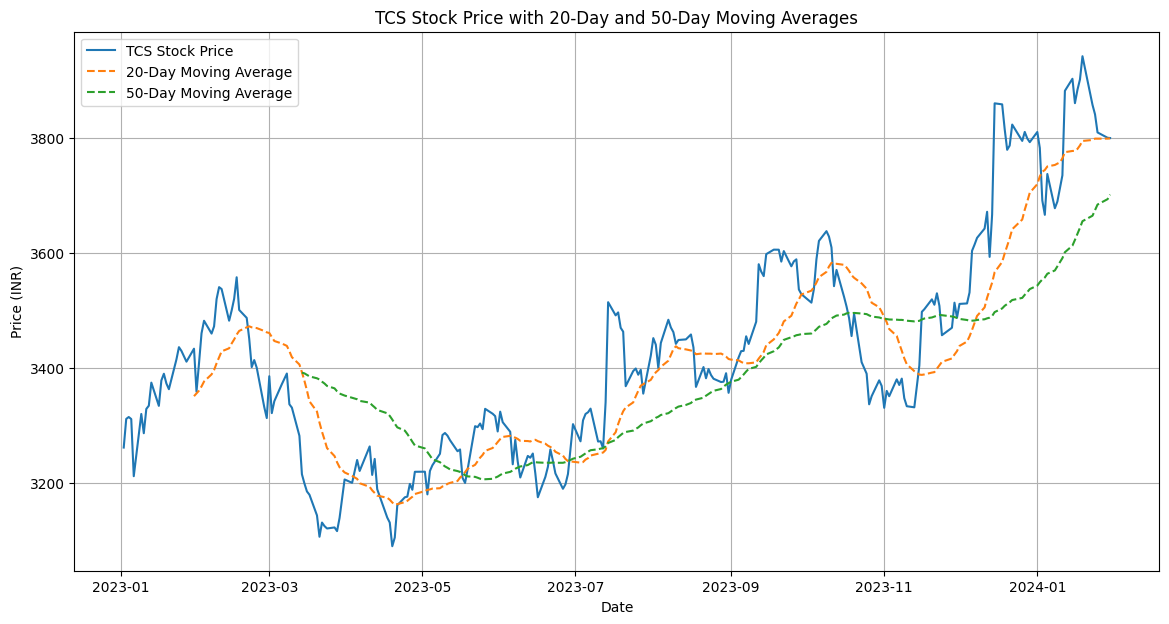

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='TCS Stock Price')
plt.plot(data['20-Day MA'], label='20-Day Moving Average', linestyle='--')
plt.plot(data['50-Day MA'], label='50-Day Moving Average', linestyle='--')
plt.title('TCS Stock Price with 20-Day and 50-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid()
plt.show()

# Technical Indicators Implementation

In [ ]:
def calculate_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Function to calculate MACD
def calculate_macd(data, short_window=24, long_window=52, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()

    return macd, signal_line

In [ ]:
# Calculate 14-day RSI
data['RSI'] = calculate_rsi(data, 14)
# Calculate MACD and signal line
data['MACD'], data['Signal Line'] = calculate_macd(data)

In [ ]:
# Drop rows with NaN values in RSI and MACD calculations
data.dropna(subset=['RSI', 'MACD', 'Signal Line'], inplace=True)

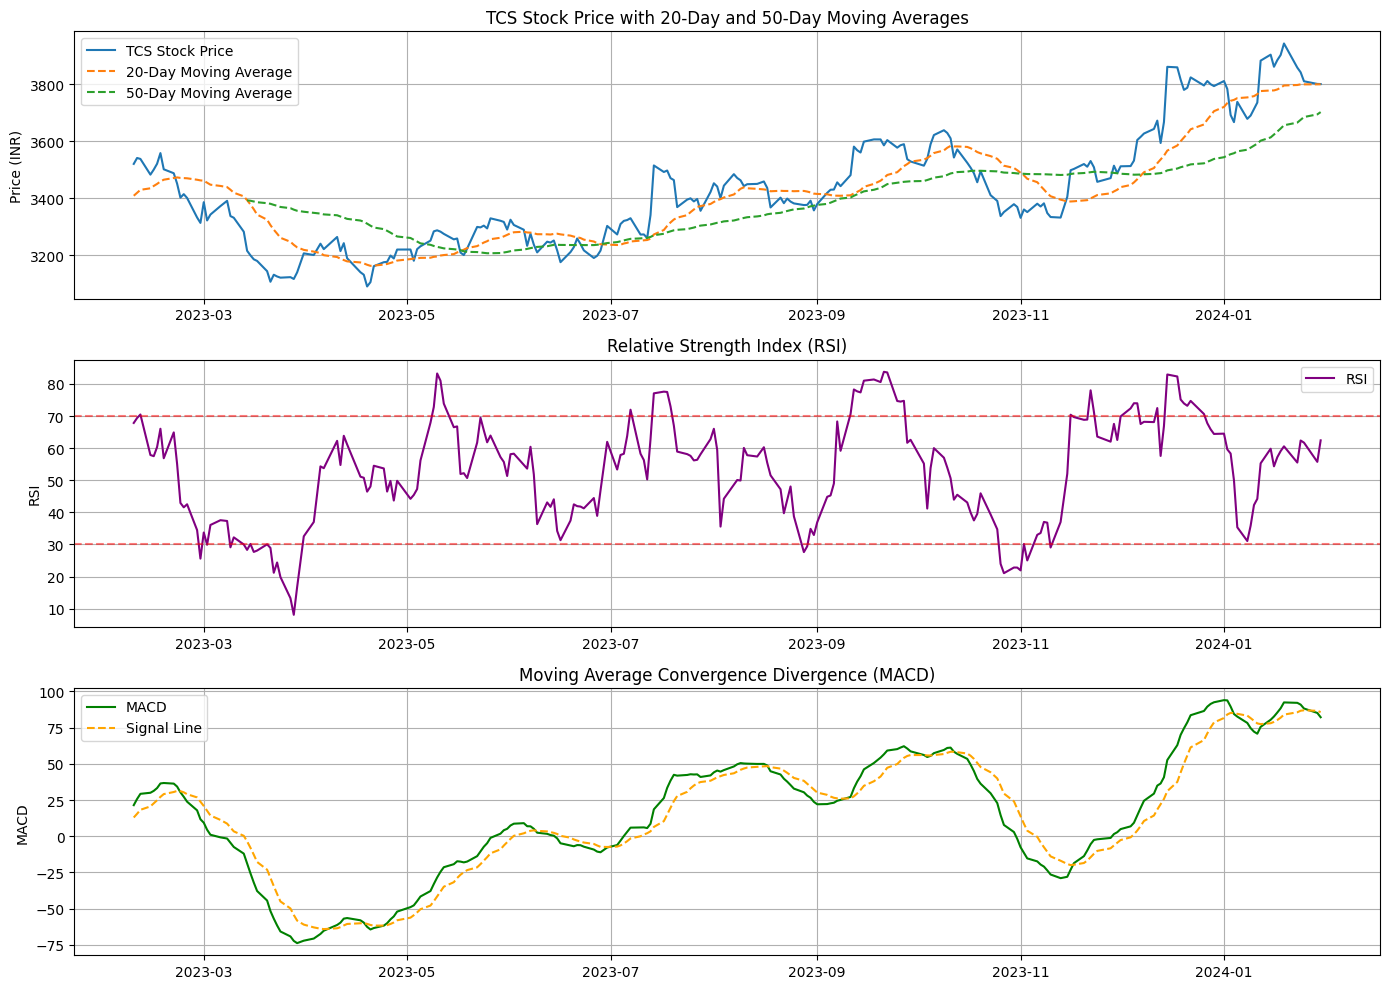

In [ ]:
# Plot the stock price, RSI, and MACD
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,10))
ax1.plot(data['Close'], label='TCS Stock Price')
ax1.plot(data['20-Day MA'], label='20-Day Moving Average', linestyle='--')
ax1.plot(data['50-Day MA'], label='50-Day Moving Average', linestyle='--')
ax1.set_title('TCS Stock Price with 20-Day and 50-Day Moving Averages')
ax1.set_ylabel('Price (INR)')
ax1.legend()
ax1.grid()

# Plot RSI
ax2.plot(data['RSI'], label='RSI', color='purple')
ax2.axhline(30, linestyle='--', alpha=0.5, color='red')
ax2.axhline(70, linestyle='--', alpha=0.5, color='red')
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI')
ax2.legend()
ax2.grid()

# Plot MACD
ax3.plot(data['MACD'], label='MACD', color='green')
ax3.plot(data['Signal Line'], label='Signal Line', color='orange', linestyle='--')
ax3.set_title('Moving Average Convergence Divergence (MACD)')
ax3.set_ylabel('MACD')
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()

# Backtesting a Simple Crossover strategy

In [ ]:
import numpy as np

In [ ]:
def calculate_moving_averages(prices, short_window=20, long_window=50):
  short_ma = prices.rolling(window=short_window).mean()
  long_ma = prices.rolling(window=long_window).mean()
  return short_ma, long_ma

def backtest_strategy(prices, short_ma, long_ma):
  signals = pd.DataFrame(index=prices.index)
  signals['price'] = prices
  signals['short_ma'] = short_ma
  signals['long_ma'] = long_ma
  signals['signal'] = 0
  signals.loc[short_ma > long_ma, 'signal'] = 1
  signals.loc[short_ma <= long_ma, 'signal'] = 0
  signals['positions'] = signals['signal'].diff()
  return signals

def plot_signals(signals):
  plt.figure(figsize=(14, 7))
  plt.plot(signals['price'], label='Price')
  plt.plot(signals['short_ma'], label='20-day MA')
  plt.plot(signals['long_ma'], label='50-day MA')
  plt.plot(signals[signals['positions'] == 1].index, signals['short_ma'][signals['positions'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
  plt.plot(signals[signals['positions'] == -1].index, signals['short_ma'][signals['positions'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
  plt.legend()
  plt.show()

def calculate_performance(signals):
  initial_capital = 100000.0
  positions = pd.DataFrame(index=signals.index).fillna(0.0)
  portfolio = pd.DataFrame(index=signals.index).fillna(0.0)

  positions['stock'] = signals['signal'] * 100  # Assuming we buy/sell 100 shares
  portfolio['positions'] = positions.multiply(signals['price'], axis=0)
  portfolio['cash'] = initial_capital - (positions.diff().multiply(signals['price'], axis=0)).cumsum()
  portfolio['total'] = portfolio['positions'] + portfolio['cash']
  portfolio['returns'] = portfolio['total'].pct_change()

  # Calculate total return
  total_return = (portfolio['total'][-1] / initial_capital) - 1
  print(f"Total Return: {total_return * 100:.2f}%")

  # Calculate Sharpe ratio
  sharpe_ratio = np.sqrt(252) * (portfolio['returns'].mean() / portfolio['returns'].std())
  print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

  # Plot equity curve
  plt.figure(figsize=(14, 7))
  plt.plot(portfolio['total'], label='Equity Curve')
  plt.title('Equity Curve')
  plt.xlabel('Date')
  plt.ylabel('Portfolio Value (INR)')
  plt.legend()
  plt.grid()
  plt.show()

  return portfolio

In [ ]:
data = yf.download('TCS.NS', start='2023-01-01', end='2024-01-01')
prices = data['Close']
short_ma, long_ma = calculate_moving_averages(prices)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
signals = backtest_strategy(prices, short_ma, long_ma)

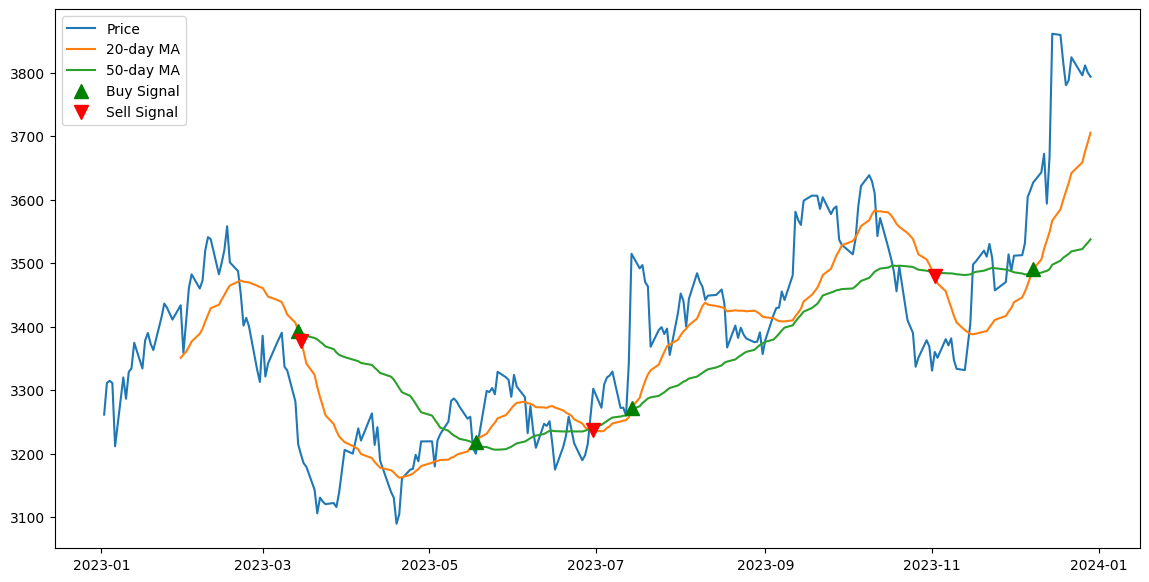

In [ ]:
plot_signals(signals)

Total Return: 9.85%
Sharpe Ratio: 0.44


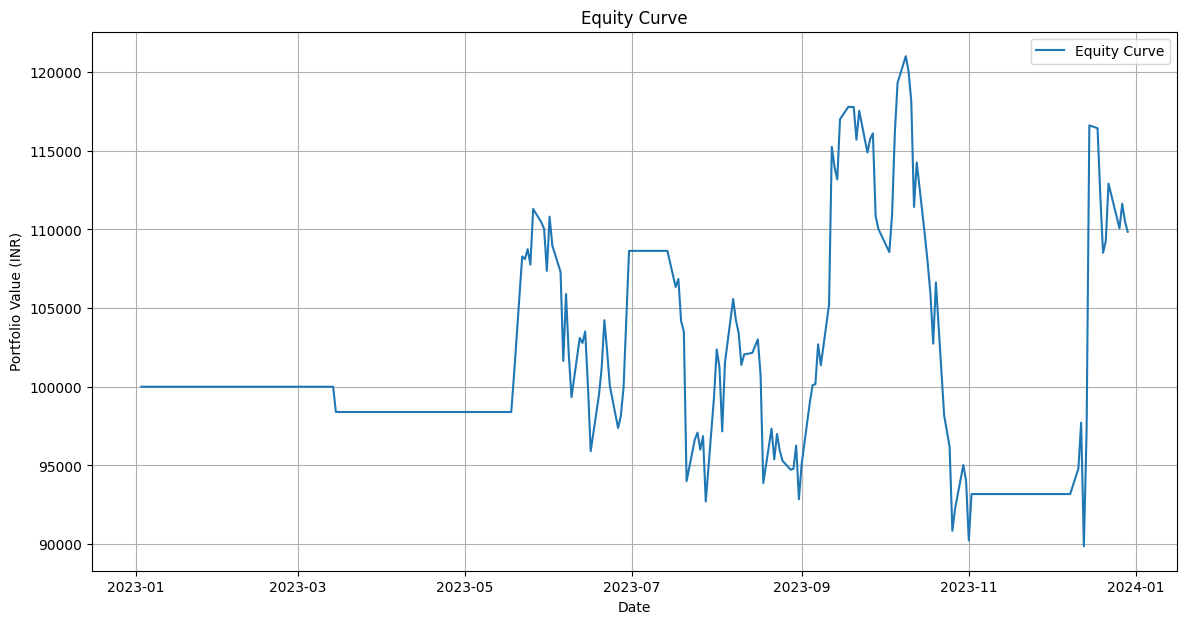

In [ ]:
portfolio = calculate_performance(signals)

Performance indicates a poor strategy, with very low returns.

Holding the stock for a year would have yielded better returns.

Sharpe Ratio also suggests that it was a very low risk, low reward strategy. Ideally, as a trader, one would like higher returns with calculated risk.